<a href="https://colab.research.google.com/github/lkarjun/fastai-workouts/blob/master/Lesson_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package

In [ ]:
!pip install fastai==2.5.3

     |████████████████████████████████| 189 kB 4.3 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai.vision.all import *

import fastai
fastai.__version__

'2.5.3'

# Convolutions

In [ ]:
top_edge = tensor([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]]).float()

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

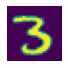

In [ ]:
im3 = Image.open(path/'train/3/12.png')

show_image(im3);

In [ ]:
im3_t = tensor(im3)

im3_t[0:3, 0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [ ]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

In [ ]:
df = pd.DataFrame(im3_t[3:10, :20])

df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
3,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
4,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
5,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [ ]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [ ]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

In [ ]:
def apply_kernel(row, col, kernel):
  transform = (im3_t[row-1: row+2, col-1:col+2]*kernel).sum()
  return transform

In [ ]:
apply_kernel(5,7,top_edge)

tensor(762.)

In [ ]:
# to get a grid of coordinates we can use a nested list comprehension

In [ ]:
[[(i, j) for j in range(1, 5)] for i in range(1, 5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

In [ ]:
rng = range(1, 27)

top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])

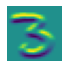

In [ ]:
show_image(top_edge3);

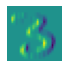

In [ ]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()


left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);

# Convolution in PyTorch

The reason for these extra axes is that PyTorch has a few tricks up its sleeve. The first trick is that PyTorch can apply a convolution to multiple images at the same time. That means we can call it on every item in a batch at once!

The second trick is that PyTorch can apply multiple kernels at the same time. So let's create the diagonal-edge kernels too, and then stack all four of our edge kernels into a single tensor:

In [ ]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()


In [ ]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [ ]:
mnist = DataBlock(
            (ImageBlock(cls=PILImageBW), CategoryBlock),
            get_items = get_image_files,
            splitter = GrandparentSplitter(),
            get_y = parent_label      
          )

In [ ]:
dls = mnist.dataloaders(path)

In [ ]:
xb, yb = first(dls.valid)

xb.shape, yb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [ ]:
xb, yb = to_cpu(xb), to_cpu(yb)

We'll see how to handle more than one channel later in this chapter. Kernels passed to F.conv2d need to be rank-4 tensors: [channels_in, features_out, rows, columns]. edge_kernels is currently missing one of these. We need to tell PyTorch that the number of input channels in the kernel is one, which we can do by inserting an axis of size one (this is known as a unit axis) in the first location, where the PyTorch docs show in_channels is expected. To insert a unit axis into a tensor, we use the unsqueeze method:



In [ ]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [ ]:
edge_kernels = edge_kernels.unsqueeze(1)

In [ ]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

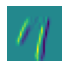

In [ ]:
show_image(batch_features[0,0]);

## Strides and Padding

In an image of size h by w, using a padding of 1 and a stride of 2 will give us a result of size (h+1)//2 by (w+1)//2. The general formula for each dimension is (n + 2*pad - ks)//stride + 1, where pad is the padding, ks, the size of our kernel, and stride is the stride

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [ ]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [ ]:
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
)

In [ ]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [ ]:
def conv(ni, nf, ks = 3, act = True):
  res = nn.Conv2d(ni, nf, stride = 2, kernel_size = ks, padding = ks//2)
  if act: res = nn.Sequential(res, nn.ReLU())
  return res

In [ ]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)

In [ ]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [ ]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [ ]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [ ]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.064771,0.027524,0.990186,00:17
1,0.018874,0.015670,0.995093,00:16


In [ ]:
xb[0].shape

torch.Size([1, 28, 28])

# Understanding Convolution Arithmetic

In [39]:
m = learn.model[0]

m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [40]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

In [41]:
m[0].bias.shape

torch.Size([4])

# Color Images

In [42]:
im = image2tensor(Image.open("bear.png"))

im.shape

torch.Size([4, 286, 244])

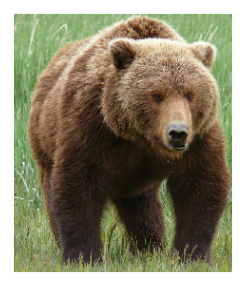

In [44]:
show_image(im);

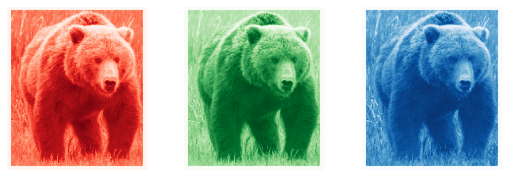

In [45]:
_, axs = subplots(1, 3)

for bear, ax, color in zip(im, axs, ("Reds", "Greens", "Blues")):
  show_image(255-bear, ax = ax, cmap = color)

# Improving Training Stability

In [46]:
path = untar_data(URLs.MNIST)

In [47]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [48]:
def get_dls(bs = 64):
  block = DataBlock(
            blocks = (ImageBlock(cls=PILImageBW), CategoryBlock),
            get_items = get_image_files,
            splitter = GrandparentSplitter('training', 'testing'),
            get_y = parent_label,
            batch_tfms = Normalize()
  ).dataloaders(path, bs = bs)
  return block

In [49]:
dls = get_dls()

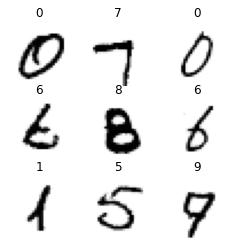

In [50]:
dls.show_batch(max_n=9, figsize=(4,4))

## Simple BaseLine

Consider the kernel that is being applied to each pixel. By default, we use a 3×3-pixel kernel. That means that there are a total of 3×3 = 9 pixels that the kernel is being applied to at each location. Previously, our first layer had four output filters. That meant that there were four values being computed from nine pixels at each location. Think about what happens if we double this output to eight filters. Then when we apply our kernel we will be using nine pixels to calculate eight numbers. That means it isn't really learning much at all: the output size is almost the same as the input size. Neural networks will only create useful features if they're forced to do so—that is, if the number of outputs from an operation is significantly smaller than the number of inputs.

To fix this, we can use a larger kernel in the first layer. If we use a kernel of 5×5 pixels then there are 25 pixels being used at each kernel application. Creating eight filters from this will mean the neural net will have to find some useful features:

In [51]:
def conv(input, filters, kernel = 3, activation = True):
  res = nn.Conv2d(input, filters, stride = 2, kernel_size=kernel, padding = kernel//2)
  if activation: res = nn.Sequential(res, nn.ReLU())
  return res

In [52]:
def simple_cnn():
  return sequential(
      conv(1, 8, kernel=5),
      conv(8, 16),
      conv(16, 32),
      conv(32, 64),
      conv(64, 10, activation=False),
      Flatten()
  )

In [54]:
from fastai.callback.hook import *

In [56]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [57]:
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.304436,2.309648,0.113500,01:01


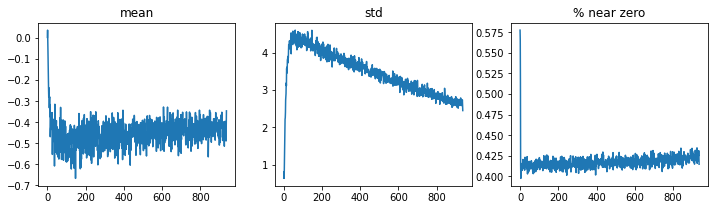

In [64]:
learn.activation_stats.plot_layer_stats(0)

Generally our model should have a consistent, or at least smooth, mean and standard deviation of layer activations during training. Activations near zero are particularly problematic, because it means we have computation in the model that's doing nothing at all (since multiplying by zero gives zero). When you have some zeros in one layer, they will therefore generally carry over to the next layer... which will then create more zeros. Here's the penultimate layer of our network:

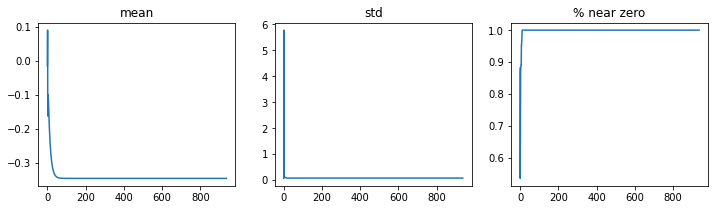

In [65]:
learn.activation_stats.plot_layer_stats(-2)

## Increase Batch size

In [66]:
dls = get_dls(512)

In [67]:
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.539544,0.312398,0.897500,00:56


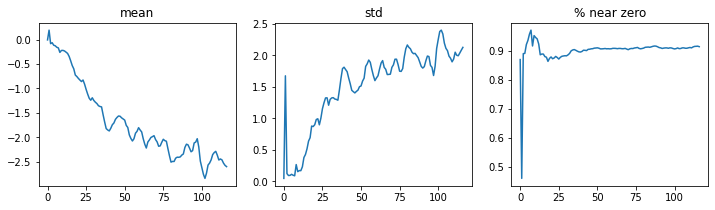

In [68]:
learn.activation_stats.plot_layer_stats(-2)

# One Cycle Training

 learning rate separated into two phases: one where the learning rate grows from the minimum value to the maximum value (warmup), and one where it decreases back to the minimum value (annealing)

1cycle training allows us to use a much higher maximum learning rate than other types of training, which gives two benefits:

By training with higher learning rates, we train faster—a phenomenon Smith named super-convergence.
By training with higher learning rates, we overfit less because we skip over the sharp local minima to end up in a smoother (and therefore more generalizable) part of the loss.

In [69]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [70]:
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.210982,0.074359,0.977200,00:56


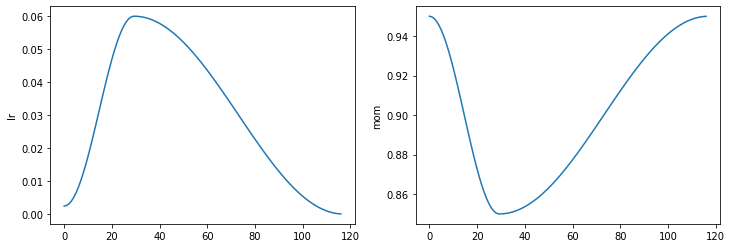

In [71]:
learn.recorder.plot_sched()

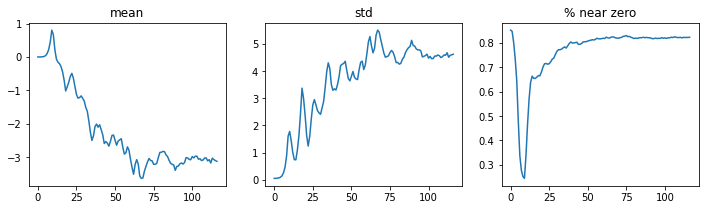

In [72]:
learn.activation_stats.plot_layer_stats(-2)

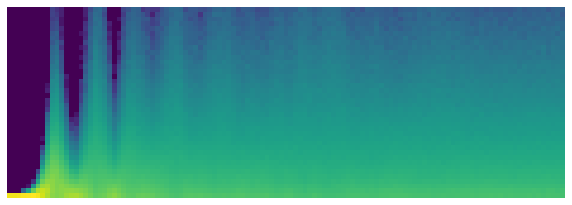

In [73]:
learn.activation_stats.color_dim(-2)

# Batch Normalization